In [1]:
try:
    import albumentations as A, einops  # noqa
    print("Albumentations & Einops found ✅")
except Exception:
    !pip install -q albumentations==1.4.11 einops
    import albumentations as A  # noqa

import os, glob, random, math, time
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Albumentations & Einops found ✅
Using device: cuda


In [2]:
class LGGSegmentationDataset(Dataset):
    """
    Expects the Kaggle LGG dataset directory:
    /kaggle/input/lgg-mri-segmentation/kaggle_3m/<PATIENT>/*.tif (and *_mask.tif)
    Works for .tif or .png/.jpg with *_mask suffix for masks.
    Returns tensors with shape [1, H, W] for both image and mask.
    """
    def __init__(self, root_dir, img_size=256, aug=False):
        self.img_size = int(img_size)
        self.samples = []
        self.aug = aug

        # Supported image extensions (including common variants)
        exts = ("*.tif", "*.png", "*.jpg", "*.jpeg")

        # Collect paired (image, mask) paths
        for patient in sorted(os.listdir(root_dir)):
            pdir = os.path.join(root_dir, patient)
            if not os.path.isdir(pdir):
                continue

            img_files = []
            for e in exts:
                img_files.extend(glob.glob(os.path.join(pdir, e)))

            # Exclude files that are already masks
            img_files = [p for p in img_files if "_mask" not in os.path.basename(p)]
            for img_path in sorted(img_files):
                mask_path = None
                base = os.path.splitext(img_path)[0]
                for me in [
                    base + "_mask.tif",
                    base + "_mask.png",
                    base + "_mask.jpg",
                    base + "_mask.jpeg",
                ]:
                    if os.path.exists(me):
                        mask_path = me
                        break
                if mask_path is not None:
                    self.samples.append((img_path, mask_path))

        print(f"Loaded {len(self.samples)} pairs from {root_dir}")

        # Albumentations pipeline (same transforms applied to image + mask)
        self.train_tf = A.Compose([
            A.Resize(self.img_size, self.img_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.RandomRotate90(p=0.2),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.3, border_mode=0),
            A.RandomBrightnessContrast(p=0.3),
        ], additional_targets={"mask": "mask"})

        self.val_tf = A.Compose([
            A.Resize(self.img_size, self.img_size),
        ], additional_targets={"mask": "mask"})

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        # Load as grayscale image to match original intent
        img = np.array(Image.open(img_path).convert("L"))   # [H, W], 0..255
        mask = np.array(Image.open(mask_path).convert("L")) # [H, W], 0..255

        # Normalize and binarize mask
        mask = (mask > 0).astype(np.float32)

        tf = self.train_tf if self.aug else self.val_tf
        # Albumentations returns a dict with 'image' and 'mask'
        augmented = tf(image=img, mask=mask)
        img_aug = augmented["image"]
        mask_aug = augmented["mask"]

        # Move to channel-first PyTorch tensors
        img_tensor = (img_aug.astype(np.float32) / 255.0)[None, ...]  # [1, H, W]
        mask_tensor = mask_aug.astype(np.float32)[None, ...]           # [1, H, W]

        return torch.from_numpy(img_tensor), torch.from_numpy(mask_tensor)


# --------- Create splits and loaders ---------

DATA_ROOT = os.path.join("/kaggle", "input", "lgg-mri-segmentation", "kaggle_3m")
full_dataset = LGGSegmentationDataset(DATA_ROOT, img_size=256, aug=False)

n_total = len(full_dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train

train_subset, val_subset = random_split(full_dataset, [n_train, n_val], generator=torch.Generator().manual_seed(SEED))

# Enable augmentation for training subset
train_subset.dataset.aug = True
val_subset.dataset.aug = False

BATCH_SIZE = 8

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_subset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print(f"Train: {len(train_subset)} | Val: {len(val_subset)}")

Loaded 3929 pairs from /kaggle/input/lgg-mri-segmentation/kaggle_3m
Train: 3143 | Val: 786


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [3]:
from pathlib import Path
import warnings

# Set a consistent working directory and create output folders
WORK_DIR = Path("/kaggle/working")

# Define all output directories under WORK_DIR
PROCESSED_DATA_DIR = WORK_DIR / "processed" / "lgg"
LOGS_DIR = WORK_DIR / "logs"
CHECKPOINTS_DIR = WORK_DIR / "checkpoints"
VISUALS_DIR = WORK_DIR / "visuals"
METADATA_DIR = WORK_DIR / "metadata"

# Create directories if they don't exist
for d in [PROCESSED_DATA_DIR, LOGS_DIR, CHECKPOINTS_DIR, VISUALS_DIR, METADATA_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Ignore the Albumentations warning (if you still want to suppress it)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
import torch
import torch.nn as nn

# =================================
# DoubleConv with optional MaxPooling
# =================================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, apply_pool=True):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        self.encode = nn.Sequential(*layers)
        self.pool = nn.MaxPool2d(2) if apply_pool else None

    def forward(self, x):
        feat = self.encode(x)       # features before pooling (for skip)
        if self.pool is not None:
            down = self.pool(feat)  # pooled for next stage
            return feat, down
        return feat                 # bottleneck → no pooling



In [5]:
# =================================
# Original UNet (128-256-512-1024 encoder)
# =================================
class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1):
        super().__init__()
        # Encoder
        self.enc1 = DoubleConv(in_ch, 128)
        self.enc2 = DoubleConv(128, 256)
        self.enc3 = DoubleConv(256, 512)
        self.enc4 = DoubleConv(512, 1024, apply_pool=False)

        # Decoder
        self.up0  = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec0 = DoubleConv(1024, 512, apply_pool=False)

        self.up1  = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec1 = DoubleConv(512, 256, apply_pool=False)

        self.up2  = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128, apply_pool=False)

        # Output
        self.outc = nn.Conv2d(128, out_ch, 1)

    def forward(self, x):
        # Encoder
        x1, p1 = self.enc1(x)
        x2, p2 = self.enc2(p1)
        x3, p3 = self.enc3(p2)
        x4     = self.enc4(p3)

        # Decoder
        x = self.up0(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.dec0(x)

        x = self.up1(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec1(x)

        x = self.up2(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec2(x)

        return self.outc(x)  # logits




In [6]:
# =================================
# Attention U-Net (same-style attention)
# =================================
class AttentionBlock(nn.Module):
    def __init__(self, g_ch, x_ch, int_ch):
        super().__init__()
        self.Wg = nn.Conv2d(g_ch, int_ch, 1, bias=False)
        self.Wx = nn.Conv2d(x_ch, int_ch, 1, bias=False)
        self.psi = nn.Conv2d(int_ch, 1, 1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
    def forward(self, g, x):
        psi = self.relu(self.Wg(g) + self.Wx(x))
        psi = self.sigmoid(self.psi(psi))
        return x * psi

class AttentionUNet(UNet):
    def __init__(self, in_ch=1, out_ch=1):
        super().__init__(in_ch, out_ch)
        # add attentions at skip connections (channels must match the skip features)
        self.att0 = AttentionBlock(512, 512, 128)  # for skip x3
        self.att1 = AttentionBlock(256, 256, 64)   # for skip x2
        self.att2 = AttentionBlock(128, 128, 32)   # for skip x1

    def forward(self, x):
        # Encoder
        x1, p1 = self.enc1(x)
        x2, p2 = self.enc2(p1)
        x3, p3 = self.enc3(p2)
        x4     = self.enc4(p3)

        # Decoder with attention gates
        x = self.up0(x4)
        x3 = self.att0(x, x3)   # attention on skip
        x = torch.cat([x, x3], dim=1)
        x = self.dec0(x)

        x = self.up1(x)
        x2 = self.att1(x, x2)
        x = torch.cat([x, x2], dim=1)
        x = self.dec1(x)

        x = self.up2(x)
        x1 = self.att2(x, x1)
        x = torch.cat([x, x1], dim=1)
        x = self.dec2(x)

        return self.outc(x)


In [7]:
# =================================
# SimpleUNet — smaller, configurable base channels
# =================================
class SimpleUNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base=64):
        """
        Simpler U-Net with base channels configurable (default 64).
        Good for quick experiments or limited memory.
        """
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base)
        self.enc2 = DoubleConv(base, base*2)
        self.enc3 = DoubleConv(base*2, base*4)
        self.enc4 = DoubleConv(base*4, base*8, apply_pool=False)

        self.up1  = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.dec1 = DoubleConv(base*8, base*4, apply_pool=False)

        self.up2  = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = DoubleConv(base*4, base*2, apply_pool=False)

        self.up3  = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec3 = DoubleConv(base*2, base, apply_pool=False)

        self.outc = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        x1, p1 = self.enc1(x)
        x2, p2 = self.enc2(p1)
        x3, p3 = self.enc3(p2)
        x4     = self.enc4(p3)

        x = self.up1(x4)
        x = torch.cat([x, x3], dim=1); x = self.dec1(x)

        x = self.up2(x)
        x = torch.cat([x, x2], dim=1); x = self.dec2(x)

        x = self.up3(x)
        x = torch.cat([x, x1], dim=1); x = self.dec3(x)

        return self.outc(x)


In [8]:
# =================================
# ResUNet (residual blocks) — adapted from your sample
# =================================
class ResidualBlock(nn.Module):
    """
    A residual block with two conv layers and optional 1x1 shortcut.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection if channels differ
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = x + shortcut
        return self.relu(x)


class ResUNet(nn.Module):
    """
    Residual U-Net — uses ResidualBlock for encoder & decoder.
    base controls the channel depth (64 recommended).
    """
    def __init__(self, in_ch=1, out_ch=1, base=64):
        super().__init__()

        # Encoder
        self.encoder1 = ResidualBlock(in_ch, base)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = ResidualBlock(base, base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = ResidualBlock(base*2, base*4)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = ResidualBlock(base*4, base*8)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ResidualBlock(base*8, base*16)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(base*16, base*8, kernel_size=2, stride=2)
        self.decoder1 = ResidualBlock(base*16, base*8)

        self.upconv2 = nn.ConvTranspose2d(base*8, base*4, kernel_size=2, stride=2)
        self.decoder2 = ResidualBlock(base*8, base*4)

        self.upconv3 = nn.ConvTranspose2d(base*4, base*2, kernel_size=2, stride=2)
        self.decoder3 = ResidualBlock(base*4, base*2)

        self.upconv4 = nn.ConvTranspose2d(base*2, base, kernel_size=2, stride=2)
        self.decoder4 = ResidualBlock(base*2, base)

        # Output
        self.output_conv = nn.Conv2d(base, out_ch, kernel_size=1)

    def forward(self, x):
        # Encoder
        s1 = self.encoder1(x)
        p1 = self.pool1(s1)
        s2 = self.encoder2(p1)
        p2 = self.pool2(s2)
        s3 = self.encoder3(p2)
        p3 = self.pool3(s3)
        s4 = self.encoder4(p3)
        p4 = self.pool4(s4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder
        d1 = self.upconv1(b)
        d1 = torch.cat([d1, s4], dim=1)
        d1 = self.decoder1(d1)

        d2 = self.upconv2(d1)
        d2 = torch.cat([d2, s3], dim=1)
        d2 = self.decoder2(d2)

        d3 = self.upconv3(d2)
        d3 = torch.cat([d3, s2], dim=1)
        d3 = self.decoder3(d3)

        d4 = self.upconv4(d3)
        d4 = torch.cat([d4, s1], dim=1)
        d4 = self.decoder4(d4)

        output = self.output_conv(d4)
        return output


In [9]:
# =================================
# UNet++ (compact 3-depth nested UNet++)
# =================================
class UNetPlusPlus(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base=32):
        super().__init__()
        # Level-0..3 encoders
        self.enc0_0 = DoubleConv(in_ch, base)
        self.enc1_0 = DoubleConv(base, base*2)
        self.enc2_0 = DoubleConv(base*2, base*4)
        self.enc3_0 = DoubleConv(base*4, base*8, apply_pool=False)

        # Nested/up blocks
        self.up3_0 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        # x2_1 = up3_0(x3_0) [base*4] concat x2_0 [base*4] -> input channels = base*8
        self.conv2_1 = DoubleConv(base*8, base*4, apply_pool=False)

        self.up2_1 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        # x1_2 = up2_1(x2_1) [base*2] concat x1_0 [base*2] -> input channels = base*4
        self.conv1_2 = DoubleConv(base*4, base*2, apply_pool=False)

        self.up1_2 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        # x0_3 = up1_2(x1_2) [base] concat x0_0 [base] -> input channels = base*2
        self.conv0_3 = DoubleConv(base*2, base, apply_pool=False)

        # simpler skip decoders for final output
        self.up2_0 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec1 = DoubleConv(base*4, base*2, apply_pool=False)

        self.up1_0 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec0 = DoubleConv(base*2, base, apply_pool=False)

        # reduce fused channels (created here — NOT in forward)
        # fused = concat(d1 [base], x0_3 [base]) -> base*2
        self.reduce = nn.Conv2d(base*2, base, 1)

        self.outc = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        x0_0, p0 = self.enc0_0(x)
        x1_0, p1 = self.enc1_0(p0)
        x2_0, p2 = self.enc2_0(p1)
        x3_0      = self.enc3_0(p2)

        x2_1 = self.up3_0(x3_0)
        x2_1 = torch.cat([x2_1, x2_0], dim=1)
        x2_1 = self.conv2_1(x2_1)

        x1_2 = self.up2_1(x2_1)
        x1_2 = torch.cat([x1_2, x1_0], dim=1)
        x1_2 = self.conv1_2(x1_2)

        x0_3 = self.up1_2(x1_2)
        x0_3 = torch.cat([x0_3, x0_0], dim=1)
        x0_3 = self.conv0_3(x0_3)

        d2 = self.up2_0(x2_1)
        d2 = torch.cat([d2, x1_0], dim=1)
        d2 = self.dec1(d2)

        d1 = self.up1_0(d2)
        d1 = torch.cat([d1, x0_0], dim=1)
        d1 = self.dec0(d1)

        fused = torch.cat([d1, x0_3], dim=1)  # fused channels = base * 2
        fused = self.reduce(fused)
        out = self.outc(fused)
        return out


In [10]:


# =================================
# End of model definitions
# =================================

if __name__ == "__main__":
    # quick sanity check
    device = torch.device("cpu")
    x = torch.randn(1, 1, 256, 256, device=device)

    models = {
        "UNet": UNet(in_ch=1, out_ch=1),
        "AttentionUNet": AttentionUNet(in_ch=1, out_ch=1),
        "SimpleUNet": SimpleUNet(in_ch=1, out_ch=1, base=64),
        "ResUNet": ResUNet(in_ch=1, out_ch=1, base=32),
        "UNetPlusPlus": UNetPlusPlus(in_ch=1, out_ch=1, base=32),
    }

    for name, m in models.items():
        try:
            m = m.to(device)
            with torch.no_grad():
                y = m(x)
            params = sum(p.numel() for p in m.parameters() if p.requires_grad)
            print(f"{name}: output {tuple(y.shape)}, params {params:,}")
        except Exception as e:
            print(f"{name} failed: {e}")


UNet: output (1, 1, 256, 256), params 30,782,593
AttentionUNet: output (1, 1, 256, 256), params 30,954,849
SimpleUNet: output (1, 1, 256, 256), params 7,699,009
ResUNet: output (1, 1, 256, 256), params 8,113,601
UNetPlusPlus: output (1, 1, 256, 256), params 2,108,193


In [11]:
# ============================  
# 3) Losses & Metrics  
# ============================  
import torch
import torch.nn as nn
import torch.nn.functional as F

# ----------------------------
# Metrics
# ----------------------------
def dice_coef(pred: torch.Tensor, target: torch.Tensor, eps: float = 1e-6) -> float:
    """
    Computes the Dice coefficient between binary predictions and targets.
    Args:
        pred   : tensor [N,1,H,W] {0,1}
        target : tensor [N,1,H,W] {0,1}
    Returns:
        mean dice score (float)
    """
    inter = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2 * inter + eps) / (union + eps)
    return dice.mean().item()


def iou_score(pred: torch.Tensor, target: torch.Tensor, eps: float = 1e-6) -> float:

    inter = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - inter
    iou = (inter + eps) / (union + eps)
    return iou.mean().item()



class DiceLoss(nn.Module):
 
    def __init__(self, eps: float = 1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        probs = torch.sigmoid(logits)
        num = 2 * (probs * targets).sum(dim=(2, 3)) + self.eps
        den = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) + self.eps
        return 1 - (num / den).mean()


def combo_loss(logits: torch.Tensor, targets: torch.Tensor, bce_w: float = 0.5) -> torch.Tensor:

    bce  = F.binary_cross_entropy_with_logits(logits, targets)
    dice = DiceLoss()(logits, targets)
    return bce_w * bce + (1 - bce_w) * dice


In [12]:
# ============================
# 4) Train / Eval Utilities (AMP-updated)
# ============================
import torch
import numpy as np

def _is_cuda_device(dev):
    """Robust check whether `dev` refers to CUDA."""
    if isinstance(dev, torch.device):
        return dev.type == "cuda"
    # strings like "cuda", "cuda:0" or pathlib-like objects
    s = str(dev).lower()
    return "cuda" in s

def train_one_epoch(model, loader, opt, scaler=None, device="cuda"):
    """
    Train the model for one epoch.
    Supports Automatic Mixed Precision (AMP) if `scaler` is provided
    (use torch.amp.GradScaler(enabled=...) to create a no-op scaler on CPU).
    """
    model.train()
    running_loss = 0.0

    # detect whether AMP is enabled from the scaler (scaler may be None)
    use_amp = (scaler is not None) and getattr(scaler, "is_enabled", None) is not None and scaler.is_enabled()

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)

        if not use_amp:
            # Standard FP32 training
            logits = model(x)
            loss = combo_loss(logits, y)
            loss.backward()
            opt.step()
        else:
            # Mixed precision training (CUDA)
            # use torch.amp.autocast (new API)
            with torch.amp.autocast(enabled=True, device_type="cuda"):
                logits = model(x)
                loss = combo_loss(logits, y)

            # scale + backward + step + update
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()

        running_loss += loss.item() * x.size(0)

    return running_loss / len(loader.dataset)


@torch.no_grad()
def evaluate(model, loader, device="cuda", thresh=0.5, use_amp=False):
    """
    Evaluate model on validation/test loader.
    Computes mean IoU and Dice scores.
    If use_amp is True and device is CUDA, forward passes run inside autocast for speed/memory.
    """
    model.eval()
    dices, ious = [], []

    # decide autocast device_type when use_amp True
    if use_amp:
        ac_kwargs = dict(enabled=True, device_type="cuda")
    else:
        ac_kwargs = dict(enabled=False, device_type="cpu")

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        if use_amp:
            with torch.amp.autocast(**ac_kwargs):
                logits = model(x)
        else:
            logits = model(x)

        probs = torch.sigmoid(logits)
        pred = (probs > thresh).float()

        dices.append(dice_coef(pred, y))
        ious.append(iou_score(pred, y))

    return float(np.mean(ious)), float(np.mean(dices))




----- Training UNet -----
Epoch 01 | Loss 0.5097 | IoU 0.3853 | Dice 0.4144
Epoch 02 | Loss 0.4781 | IoU 0.5360 | Dice 0.5611
Epoch 03 | Loss 0.4748 | IoU 0.1631 | Dice 0.1996
Epoch 04 | Loss 0.4708 | IoU 0.2686 | Dice 0.3055
Epoch 05 | Loss 0.4610 | IoU 0.2971 | Dice 0.3358

----- Training AttentionUNet -----
Epoch 01 | Loss 0.5082 | IoU 0.6591 | Dice 0.6591
Epoch 02 | Loss 0.4806 | IoU 0.4826 | Dice 0.5123
Epoch 03 | Loss 0.4760 | IoU 0.6248 | Dice 0.6460
Epoch 04 | Loss 0.4707 | IoU 0.5176 | Dice 0.5471
Epoch 05 | Loss 0.4681 | IoU 0.2950 | Dice 0.3291
⏹️ Early stopping at epoch 5 (no improvement for 4 epochs)

----- Training ResUNet -----
Epoch 01 | Loss 0.4865 | IoU 0.2448 | Dice 0.2832
Epoch 02 | Loss 0.4523 | IoU 0.5122 | Dice 0.5519
Epoch 03 | Loss 0.4289 | IoU 0.5487 | Dice 0.5872
Epoch 04 | Loss 0.4199 | IoU 0.5372 | Dice 0.5790
Epoch 05 | Loss 0.4121 | IoU 0.5768 | Dice 0.6192

----- Training UNet+ -----
Epoch 01 | Loss 0.4969 | IoU 0.6109 | Dice 0.6218
Epoch 02 | Loss 0.47

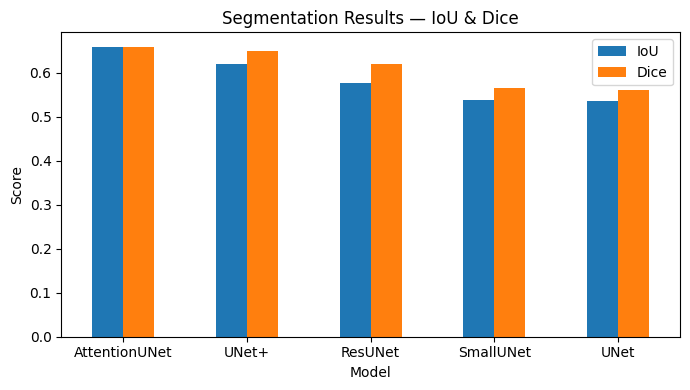

In [13]:

# ============================
# 5) Run Experiments (with Early Stopping + AMP)
# ============================
import pandas as pd
import matplotlib.pyplot as plt
import torch

EPOCHS = 5      # max epochs
LR = 1e-3
PATIENCE = 4     # stop if no improvement for N epochs

MODELS = {
    "UNet": UNet(),
    "AttentionUNet": AttentionUNet(),
    "ResUNet" : ResUNet(),
    "UNet+" : UNetPlusPlus(),
    "SmallUNet": SimpleUNet(),
}

results = []

# Device in your notebook can be a torch.device or a string — handle both robustly
# Make sure DEVICE variable is set in your notebook (e.g., torch.device("cuda") or "cuda" or "cpu")
# If not set, fall back to detecting CUDA availability.
try:
    DEVICE  # noqa: F821
except NameError:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Decide whether to use AMP: require both CUDA available and DEVICE referring to CUDA
use_amp = torch.cuda.is_available() and _is_cuda_device(DEVICE)

# Create a GradScaler that is enabled only when AMP is desired.
# On CPU this becomes a disabled/no-op scaler if enabled=False.
# Use enabled flag instead of deprecated torch.cuda.amp.GradScaler(...)
scaler_for_training = torch.amp.GradScaler(enabled=use_amp)

for name, net in MODELS.items():
    print(f"\n----- Training {name} -----")
    net = net.to(DEVICE)
    opt = torch.optim.AdamW(net.parameters(), lr=LR, weight_decay=1e-4)

    # For each model we pass the same scaler instance (it's stateful) but you can also create per-model if preferred.
    scaler = scaler_for_training if use_amp else None

    best_val = -1.0
    best_ckpt = None
    patience_counter = 0  # for early stopping

    for e in range(1, EPOCHS + 1):
        # train
        tr_loss = train_one_epoch(net, train_loader, opt, scaler, device=DEVICE)

        # validate (use_amp flag ensures autocast during forward if CUDA+AMP)
        iou, dice = evaluate(net, val_loader, device=DEVICE, use_amp=use_amp)
        print(f"Epoch {e:02d} | Loss {tr_loss:.4f} | IoU {iou:.4f} | Dice {dice:.4f}")

        # check improvement
        if dice > best_val:
            best_val = dice
            patience_counter = 0
            best_ckpt = {k: v.cpu().clone() for k, v in net.state_dict().items()}
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"⏹️ Early stopping at epoch {e} (no improvement for {PATIENCE} epochs)")
                break

    # reload best checkpoint and re-evaluate
    if best_ckpt is not None:
        net.load_state_dict(best_ckpt)
        iou, dice = evaluate(net, val_loader, device=DEVICE, use_amp=use_amp)

    results.append({"Model": name, "IoU": iou, "Dice": dice})

# ============================
# Results table & plot
# ============================
df = pd.DataFrame(results).sort_values("Dice", ascending=False).reset_index(drop=True)

print("\n=== Validation Results (higher is better) ===")
print(df)

# Bar plot
ax = df.set_index("Model")[["IoU", "Dice"]].plot(kind="bar", figsize=(7,4))
ax.set_ylabel("Score")
ax.set_title("Segmentation Results — IoU & Dice")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [14]:
# ---------------------------
# 8) Sanity check: instantiate models & forward pass (use eval to avoid BN noise)
# ---------------------------
import torch, numpy as np, cv2, matplotlib.pyplot as plt
from PIL import Image

# Define IMG_SIZE globally (keep consistent with your dataset resizing)
IMG_SIZE = 256  

if __name__ == "__main__":
    device_cpu = torch.device("cpu")
    x = torch.randn(1, 1, IMG_SIZE, IMG_SIZE, device=device_cpu)

    models = {
        "UNet": UNet(in_ch=1, out_ch=1),
        "AttentionUNet": AttentionUNet(in_ch=1, out_ch=1),
        "SimpleUNet": SimpleUNet(in_ch=1, out_ch=1, base=64),
        "ResUNet": ResUNet(in_ch=1, out_ch=1, base=32),
        "UNetPlusPlus": UNetPlusPlus(in_ch=1, out_ch=1, base=32),
    }

    for name, m in models.items():
        try:
            m = m.to(device_cpu)
            m.eval()  # eval avoids BN running-stat surprises with batch-size=1
            with torch.no_grad():
                y = m(x)
            params = sum(p.numel() for p in m.parameters() if p.requires_grad)
            print(f"{name}: output {tuple(y.shape)}, params {params:,}")
        except Exception as e:
            print(f"{name} failed: {e}")

    # Quick evaluate coverage distribution (visual)
    try:
        cov = []
        # use pairs from earlier (rename consistently)
        N = min(len(pairs), 2000)   # not pairs_all, just pairs you already built
        for _, m in pairs[:N]:
            M = np.array(Image.open(m).convert('L'))
            Msmall = cv2.resize(M, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            cov.append(100.0 * (Msmall > 0).sum() / Msmall.size)
        cov = np.array(cov)
        print(f"Coverage (first {N}) mean/std/min/max:", cov.mean(), cov.std(), cov.min(), cov.max())
        plt.hist(cov, bins=50, range=(0,100))
        plt.title("Mask coverage (%)")
        plt.xlabel("Coverage %")
        plt.ylabel("Count")
        plt.show()
    except Exception as e:
        print("Coverage plot failed:", e)

# ---------------------------
# End
# ---------------------------


UNet: output (1, 1, 256, 256), params 30,782,593
AttentionUNet: output (1, 1, 256, 256), params 30,954,849
SimpleUNet: output (1, 1, 256, 256), params 7,699,009
ResUNet: output (1, 1, 256, 256), params 8,113,601
UNetPlusPlus: output (1, 1, 256, 256), params 2,108,193
Coverage plot failed: name 'pairs' is not defined


In [15]:
# RUN: shows coverage distribution for train and val splits
import numpy as np, cv2
from tqdm import tqdm

def coverage_list(pairs, nlimit=None):
    cov=[]
    for i,(img,mask) in enumerate(pairs):
        M = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        if M is None:
            from PIL import Image
            M = np.array(Image.open(mask).convert('L'))
        Msmall = cv2.resize(M, (256,256), interpolation=cv2.INTER_NEAREST)
        cov.append(100.0*(Msmall>0).sum()/Msmall.size)
        if nlimit and i+1>=nlimit: break
    return np.array(cov)

# Build pairs list same as before
import glob, os
root="/kaggle/input/lgg-mri-segmentation/kaggle_3m"
pairs=[]
exts=("*.tif","*.png","*.jpg")
for p in sorted(os.listdir(root)):
    d=os.path.join(root,p)
    if not os.path.isdir(d): continue
    files=[]
    for e in exts: files+=glob.glob(os.path.join(d,e))
    files=[f for f in sorted(files) if "_mask" not in os.path.basename(f)]
    for img in files:
        base=os.path.splitext(img)[0]
        for m in (base+"_mask.tif", base+"_mask.png", base+"_mask.jpg"):
            if os.path.exists(m):
                pairs.append((img,m)); break

# compute coverage for first 2000 (fast)
cov = coverage_list(pairs, nlimit=2000)
print("Overall (first 2000) - mean/std/min/max:", cov.mean(), cov.std(), cov.min(), cov.max())
print("Percentiles:", np.percentile(cov, [0,1,5,25,50,75,95,99,100]).tolist())

# If you used random_split earlier, get indices from the same split and compute
# assume you used random_split(full_ds, [n_train, n_val], generator=torch.Generator().manual_seed(42))
# If you didn't store indices, just show simple counts:
print("Count of empty masks in sample:", (cov==0).sum(), "/", len(cov))


Overall (first 2000) - mean/std/min/max: 0.9890090942382812 1.8992447828839054 0.0 11.480712890625
Percentiles: [0.0, 0.0, 0.0, 0.0, 0.0, 1.1623382568359375, 5.44158935546875, 7.8813629150390625, 11.480712890625]
Count of empty masks in sample: 1334 / 2000
